In [9]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, BaggingRegressor
from sklearn.metrics import accuracy_score, classification_report, mean_squared_error
import warnings
warnings.filterwarnings('ignore')

from xgboost import XGBRegressor
import xgboost as xgb
from scipy.stats import uniform, randint
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeRegressor

In [10]:
df = pd.read_csv("klar_for_oppgave_5.csv",index_col=0)
X = df.drop(columns=["Close"])
y = df["Close"]

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [11]:
X_train.head()

,PLS_Component_1,PLS_Component_2,PLS_Component_3,PLS_Component_4,PLS_Component_5,PLS_Component_8,PLS_Component_9,PLS_Component_10,PLS_Component_12
2323,4.889292,-2.977292,1.944830,-0.947995,-0.026429,0.597677,-0.545085,-0.565256,0.383897
1042,-6.348190,4.731218,-1.824143,0.622389,-0.160912,-0.335043,0.348016,0.202034,-0.181195
2820,7.246649,-4.794195,2.807452,-0.870533,0.757662,0.276345,-0.406990,-0.128273,0.001728
2759,6.128037,-4.198443,2.182937,-0.700179,0.606949,0.163217,-0.264682,-0.106247,-0.096071
1100,-5.479450,3.571300,-2.226312,0.666937,-0.549482,-0.369109,0.372466,0.223085,-0.207036


In [12]:
y_train.head()

2323    0.640
1042    0.140
2820    0.760
2759    0.725
1100    0.170
Name: Close, dtype: float64

In [ ]:
# Step 3: Initialize a base model (e.g., DecisionTreeRegressor)
base_model = DecisionTreeRegressor(random_state=42)

# Step 4: Initialize the BaggingRegressor using the base model
bagging_model = BaggingRegressor(estimator=base_model, n_estimators=50, random_state=42)

# Step 5: Train the BaggingRegressor model
bagging_model.fit(X_train, y_train)

# Step 6: Make predictions on the test set
y_pred = bagging_model.predict(X_test)

# Step 7: Evaluate the performance using Mean Squared Error (MSE)
# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\nModel Evaluation:")
print(f"Mean Squared Error (MSE): {mse:.5f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.5f}")
print(f"Mean Absolute Error (MAE): {mae:.5f}")
print(f"R-squared (R2): {r2:.5f}")


Model Evaluation:
Mean Squared Error (MSE): 0.00012
Root Mean Squared Error (RMSE): 0.01101
Mean Absolute Error (MAE): 0.00792
R-squared (R2): 0.99756


In [23]:
# Step 8: Plotting the results
display(len(X_test), len(y_test), len(y_pred))
display(type(X_test), type(y_test), type(y_pred))

print(X_test)


626

626

626

pandas.core.frame.DataFrame

pandas.core.series.Series

numpy.ndarray

      PLS_Component_1  PLS_Component_2  PLS_Component_3  PLS_Component_4  \
1188        -4.934491         2.882576        -2.280145         0.816489   
1134        -4.916853         3.476420        -1.795428         0.389708   
2159         2.762245        -1.513999         1.271503        -0.619355   
1467        -2.957005         1.755998        -1.466533         0.369327   
1072        -6.074166         4.103423        -2.184790         0.785484   
...               ...              ...              ...              ...   
221         -3.057400         1.058736        -2.580536         0.420153   
543         -1.925097         0.099291        -1.667833         1.071877   
1323        -4.865563         3.546410        -1.394600         0.588534   
3067        11.458817        -6.706729         5.191384        -2.006960   
691         -2.757329         1.119625        -1.447559         1.067613   

      PLS_Component_5  PLS_Component_8  PLS_Component_9  PLS_Component_10  \
1188      

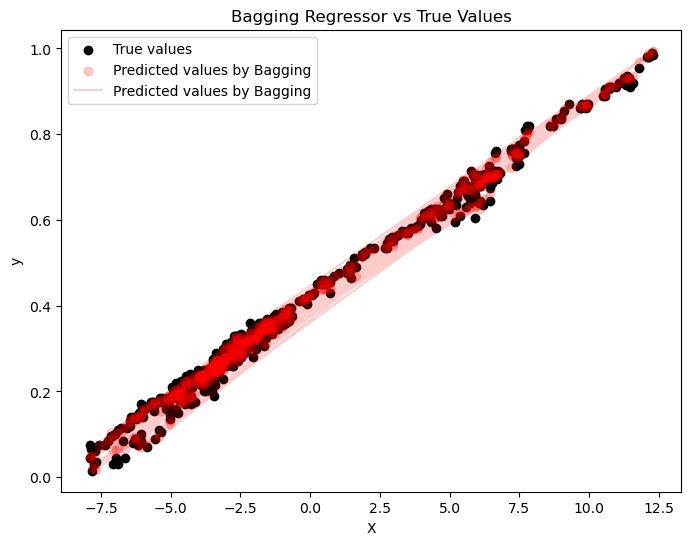

In [31]:
plt.figure(figsize=(8, 6))
plt.scatter(X_test.iloc[:,0], y_test, color='black', label='True values')
plt.scatter(X_test.iloc[:,0], y_pred, color='red', label='Predicted values by Bagging', alpha=0.2)
plt.plot(X_test.iloc[:,0], y_pred, color='red', label='Predicted values by Bagging', alpha=0.2)
plt.xlabel('X')
plt.ylabel('y')
plt.title('Bagging Regressor vs True Values')
plt.legend()
plt.show()

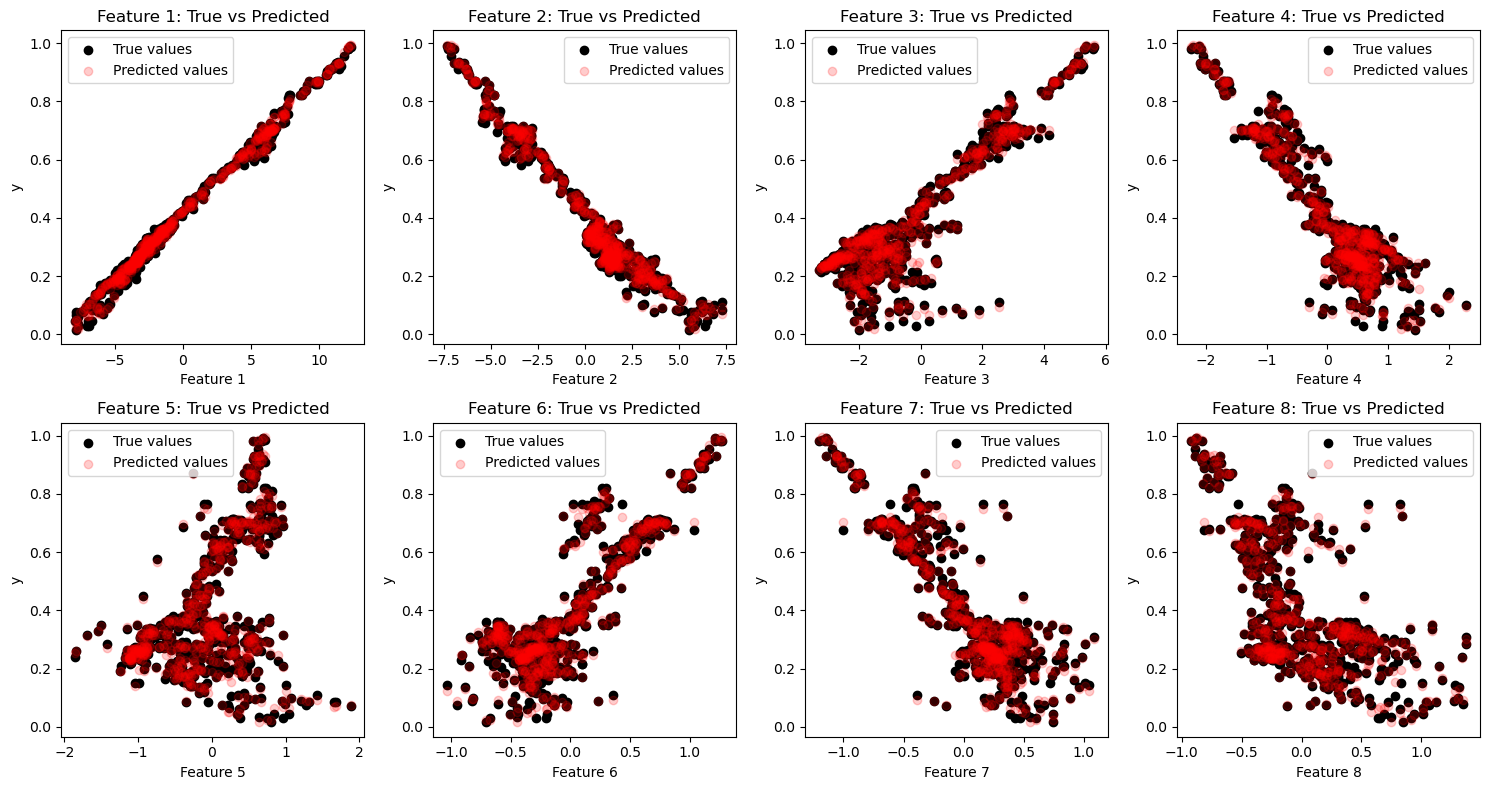

In [33]:
# Step 8: Create subplots to visualize the predictions for each feature in X_test
fig, axes = plt.subplots(2, 4, figsize=(15, 8))  # 2 rows, 4 columns (8 plots total)

# Flatten axes array for easier indexing
axes = axes.flatten()

# Plot for each feature in X_test
for i in range(8):
    ax = axes[i]
    ax.scatter(X_test.iloc[:, i], y_test, color='black', label='True values')  # True values (y_test)
    ax.scatter(X_test.iloc[:, i], y_pred, color='red', label='Predicted values', alpha=0.2)  # Predicted values (y_pred)
    
    ax.set_xlabel(f'Feature {i+1}')
    ax.set_ylabel('y')
    ax.set_title(f'Feature {i+1}: True vs Predicted')
    ax.legend()

# Adjust layout for better spacing
plt.tight_layout()
plt.show()